In [55]:
seed = 42  # for reproducibility

# Imports
import os
import sys
import enum
import copy
import random
import tempfile
import warnings
import multiprocessing
import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

# import visdom
from pathlib import Path
from tqdm import tqdm
from scipy import stats

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
torch.manual_seed(seed)
import torchio as tio
#sys.path.append(str(Path().absolute().parent))
#sys.path.append(str(Path().absolute().parent.parent))

from torchio.transforms import (
    RescaleIntensity,
    RandomElasticDeformation,
    RandomFlip,
    RandomAffine,
    # intensity
    RandomMotion,
    RandomGhosting,
    RandomSpike,
    RandomBiasField,
    RandomBlur,
    RandomNoise,
    RandomSwap,
#     RandomLabelsToImage,
    RandomGamma,
    OneOf,
    CropOrPad,
    ZNormalization,
    HistogramStandardization,
    Compose,
)


In [56]:
DDSM_mass_path = Path('/home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI')
train_path = DDSM_mass_path.joinpath('Train')
csv_file = pd.read_csv(Path('/home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI/report_processed_mass_case_description_train_set.csv'))
csv_file.head()

,Unnamed: 0,Unnamed: 0.1,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,scan_shape,mask_shape,status
0,0,0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Train/P_00001/LEFT_CC/scan.nii.gz,Train/P_00001/LEFT_CC/roi_mass_1.nii.gz,Train/P_00001/LEFT_CC/mask_mass_1.nii.gz,"(3024, 4808, 1)","(3024, 4808, 1)",OK
1,1,1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Train/P_00001/LEFT_MLO/scan.nii.gz,Train/P_00001/LEFT_MLO/roi_mass_1.nii.gz,Train/P_00001/LEFT_MLO/mask_mass_1.nii.gz,"(2656, 4800, 1)","(2656, 4800, 1)",OK
2,2,2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Train/P_00004/LEFT_CC/scan.nii.gz,Train/P_00004/LEFT_CC/roi_mass_1.nii.gz,Train/P_00004/LEFT_CC/mask_mass_1.nii.gz,"(2986, 5491, 1)","(2986, 5491, 1)",OK
3,3,3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Train/P_00004/LEFT_MLO/scan.nii.gz,Train/P_00004/LEFT_MLO/roi_mass_1.nii.gz,Train/P_00004/LEFT_MLO/mask_mass_1.nii.gz,"(3046, 5491, 1)","(3046, 5491, 1)",OK
4,4,4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Train/P_00004/RIGHT_MLO/scan.nii.gz,Train/P_00004/RIGHT_MLO/roi_mass_1.nii.gz,Train/P_00004/RIGHT_MLO/mask_mass_1.nii.gz,"(2911, 5491, 1)","(2911, 5491, 1)",OK


In [3]:
csv_file = pd.read_csv(Path('/home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI/report_processed_mass_case_description_train_set.csv'))

In [4]:
csv_file

,Unnamed: 0,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Train/P_00001/LEFT_CC/scan.nii.gz,Train/P_00001/LEFT_CC/roi_mass_1.nii.gz,Train/P_00001/LEFT_CC/mask_mass_1.nii.gz
1,1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Train/P_00001/LEFT_MLO/scan.nii.gz,Train/P_00001/LEFT_MLO/roi_mass_1.nii.gz,Train/P_00001/LEFT_MLO/mask_mass_1.nii.gz
2,2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Train/P_00004/LEFT_CC/scan.nii.gz,Train/P_00004/LEFT_CC/roi_mass_1.nii.gz,Train/P_00004/LEFT_CC/mask_mass_1.nii.gz
3,3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Train/P_00004/LEFT_MLO/scan.nii.gz,Train/P_00004/LEFT_MLO/roi_mass_1.nii.gz,Train/P_00004/LEFT_MLO/mask_mass_1.nii.gz
4,4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Train/P_00004/RIGHT_MLO/scan.nii.gz,Train/P_00004/RIGHT_MLO/roi_mass_1.nii.gz,Train/P_00004/RIGHT_MLO/mask_mass_1.nii.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,1313,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,Train/P_02033/RIGHT_MLO/scan.nii.gz,Train/P_02033/RIGHT_MLO/roi_mass_1.nii.gz,Train/P_02033/RIGHT_MLO/mask_mass_1.nii.gz
1314,1314,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Train/P_02079/RIGHT_CC/scan.nii.gz,Train/P_02079/RIGHT_CC/roi_mass_1.nii.gz,Train/P_02079/RIGHT_CC/mask_mass_1.nii.gz
1315,1315,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Train/P_02079/RIGHT_MLO/scan.nii.gz,Train/P_02079/RIGHT_MLO/roi_mass_1.nii.gz,Train/P_02079/RIGHT_MLO/mask_mass_1.nii.gz
1316,1316,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,Train/P_02092/LEFT_CC/scan.nii.gz,Train/P_02092/LEFT_CC/roi_mass_1.nii.gz,Train/P_02092/LEFT_CC/mask_mass_1.nii.gz


In [59]:
import yaml
config_file = Path('src/classification/config.yaml')
with open(config_file) as file:
  config = yaml.safe_load(file)
config['paths']['DDSM']
data_path = Path(config['paths']['DDSM']['raw'])

In [60]:
TRAIN_FOLDER = data_path / 'Train'
TEST_FOLDER = data_path / 'Test'

TRAIN_MASS_INFO_FILE = data_path / 'report_processed_mass_case_description_train_set.csv'
TEST_MASS_INFO_FILE = data_path / 'report_processed_mass_case_description_test_set.csv'

In [61]:
TRAIN_MASS_INFO_FILE

PosixPath('/home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI/report_processed_mass_case_description_train_set.csv')

In [62]:
patient_id = 'P_02092'
for patient_id in csv_file['patient_id']:
    patient_csv = csv_file.loc[csv_file['patient_id']==patient_id]
    cropped_image = list(patient_csv['cropped_image_file_path'])
    mask = list(patient_csv['ROI_mask_file_path'])
    pathology = list(patient_csv['pathology'])
    for i, ci in enumerate(cropped_image):
        subject = tio.Subject(
            img=tio.ScalarImage(data_path / ci),
            mask=tio.LabelMap(data_path / mask[i]),
            pathology=pathology[i]
            )
    break
subject['mask']

LabelMap(path: "/home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI/Train/P_00001/LEFT_MLO/mask_mass_1.nii.gz"; type: label)

In [63]:
list(cropped_image)

['Train/P_00001/LEFT_CC/roi_mass_1.nii.gz',
 'Train/P_00001/LEFT_MLO/roi_mass_1.nii.gz']

In [64]:
path_list = list(patient_csv['image_file_path'])
one_example = data_path / path_list[0]

In [65]:
def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(np.squeeze(nii.dataobj[..., k]), cmap=colormap)

def show_subject(subject, image_name, label_name=None):
    if label_name is not None:
        subject = copy.deepcopy(subject)
        affine = subject[label_name].affine
        label_image = subject[label_name].as_sitk()
        label_image = sitk.Cast(label_image, sitk.sitkUInt8)
        border = sitk.BinaryContour(label_image)
        border_array, _ = tio.utils.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)[0]
        image_tensor = subject[image_name].data[0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        subject[image_name].save(f.name)
        show_nifti(f.name)

In [26]:
test_img = data_path / patient_csv['image_file_path'][1]
print(test_img)
img = nib.load(str(test_img))
show_nifti(img)
img.shape


In [32]:
img_cropped = nib.load(str(data_path / patient_csv['cropped_image_file_path'][1]))
show_nifti(img_cropped)
img_cropped.shape

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

(256, 292, 1)

In [72]:
import torchio as tio
scan_img = data_path / patient_csv['image_file_path'][1]
print(scan_img)
mask_img = data_path / patient_csv['ROI_mask_file_path'][1]
print(mask_img)

subject = tio.Subject(
    scan=tio.ScalarImage(scan_img),
    mask_mass=tio.LabelMap(mask_img),
)
print(subject.scan.shape)
transform = tio.CropOrPad(
    (256, 256, 1),
    mask_name='mask_mass',
)
transformed = transform(subject)
print(transformed.scan.shape)

/home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI/Train/P_00001/LEFT_MLO/scan.nii.gz
/home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI/Train/P_00001/LEFT_MLO/mask_mass_1.nii.gz
(1, 2656, 4800, 1)
(1, 256, 256, 2)


In [73]:
from src.classification import data_loader
d = data_loader.BreastDataLoader()
t, v = d.get_dataset(1)

Loading /home/lidia/Datasets/TCIA/DDSM/CBIS-DDSM-NIFTI/Train
Total number of subject instances is 3133
Normal count is 1724
Rest is 1409
{'MALIGNANT', 'BENIGN'}
Fold 1, Training set length: 2506, validation: 627
Training set: 2506 subjects
Validation set: 627 subjects


In [48]:
v[1]['patient_id']

'P_00004'

In [49]:
v[1]['img']['data'].shape

torch.Size([1, 256, 256, 2])

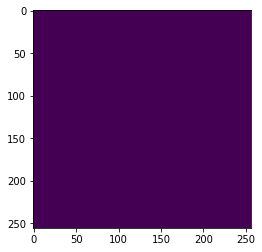

In [50]:
plt.imshow(v[3]['img']['data'][...,0].squeeze(0))

In [51]:
v[3]['img']['data'].shape

torch.Size([1, 256, 256, 2])

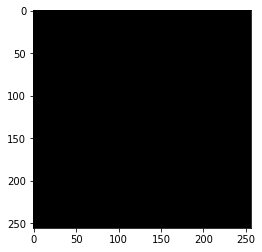

In [45]:
plt.imshow(v[3]['img']['data'][0,...,0], cmap='gray')

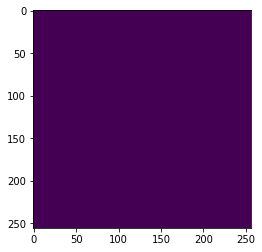

In [52]:
plt.imshow(v[3]['mask']['data'][...,0].squeeze(0))

In [53]:
t, v = d.load(0)
one = next(iter(t))

Fold 0, Training set length: 2506, validation: 627
Training set: 2506 subjects
Validation set: 627 subjects
Training with a batch size of: 10 and validation batch size: 10


In [40]:
import torchvision
inputs = one['img']['data']
img_grid = torchvision.utils.make_grid(inputs[:,0,...,0].unsqueeze(1), normalize=True, scale_each=True)

In [41]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='/home/linardos/workenv/mnm/src/visualizations/log')

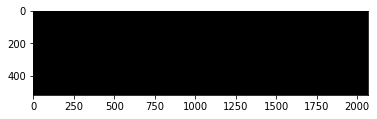

In [42]:
for img in img_grid:
    plt.imshow(img, cmap='gray')

In [43]:
# https://discuss.pytorch.org/t/tensorboard-image-quality-lower-than-matplotlib/58233/4
writer.add_image('MRI', img_grid)
writer.close()

In [44]:
t, v = d.get_dataset(0)


Fold 0, Training set length: 2603, validation: 651
Training set: 2603 subjects
Validation set: 651 subjects


In [45]:
show_subject(t[10], 'mri')

KeyError: 'mri'

In [ ]:
mri = one['mri']['data'][0][0]
mask = one['gt']['data'][0][0]

In [ ]:
mask.shape

In [ ]:
lv = torch.zeros(mask.shape)
lv[mask==1]=1